# Exercise 02: Analysing Bias and Inequalities in OSM

## Motivation
Administrative or "official" geodatasets usually try to reach the same level of coverage and quality for an entire country or federal state. In contrast, the coverage of OSM is not the same in any place of the world. There are places with a large active OSM community and others where nothing has been mapped at all. Without going deeper into the topic of data quality, the spatial (and temporal) distribution of mapping around the globe can already tell us many interesting properties of OSM. By analysing the spatial temporal footprint of mapping activity in OSM we can identify regions with stronger local communities and can also find out how mapping is organized on larger scales.

> Overall, mapping in OSM was strongly biased towards regions with very high Human Development Index. However, humanitarian mapping efforts had a different footprint, predominantly focused on regions with medium and low human development. Despite these efforts, regions with low and medium human development only accounted for 28% of the buildings and 16% of the roads mapped in OSM although they were home to 46% of the global population. {cite}`Herfort2021`

This variability in mapping does not only become visible in the overall spatial coverage of OSM, but also when investigating how much individual users are contributing to the map.

>"Not all users contribute equally to the map. OSM is no exception to the 90-9-1 rule found in online communities where only a small number of active contributors account for most of the contributions. By our calculations for OSM, the top 1.4% of editors are responsible for 90% of all the map changes."  {cite}`Anderson2019`

>"The results show that only 38% (192,000) of the registered members carried out at least one edit in the OSM database and that only 5% (24,000) of all members actively contributed to the project in a more productive way." {cite}`Neis2012`

```{figure} ../figs/anderson_et_al_corporate_editors.png
---
height: 350px
name: jennings-map-corporate-mappers
---
Places where corporate editors are editing. (source: {cite}`Anderson2019`)
```


## How biased is the global distribution of OSM contributions?

This exercise will investigate the global spatial distribution of mapping in OSM for 5 days in 2020-02. We will use the changesets from OSM as they allow us to distinguish mapping by user, specific changeset comments (often used to identify a certain mapping campaign or group) and contain the rough locations of the map changes. To get an overview, analysing the changesets is often a quick and relatively simple approach. To get a first idea of OSM's global footprint you don't need to start with taking a look at every single element, which might get too complicated very soon. So let's start with something simpler.

### 1. Download OSM Changesets
On [HeiBOX](https://heibox.uni-heidelberg.de/f/87fe1933837e4e5491fd/) you can download an geopackage file. This file contains the OSM changesets for the time of 2020-02-01 to 2020-02-06. We'll work on this smaller extract to make sure that computations don't take too long.

```{note}
In principle, it's of course also interesting to take a look at all 100,000,000+ changesets contributed so far to OSM. For this you could set up your own database containing all OSM changesets. You will find an overview on how to do it [here](https://github.com/ToeBee/ChangesetMD). Since this process took several hours for me, it might be easier for you to get started with the geopackage provided for download.
```

Also make sure to get two csv files we are going to use later:
* <a href="../../_static/data/facebook_users.csv">facebook_users.csv</a>
* <a href="../../_static/data/apple_users.csv">apple_users.csv</a>

### 2. Get an overview
Connect to the geopackage in QGIS and load the Polygon layer to get an overview on the spatial coverage.

````{dropdown} Show the result in QGIS.
```{figure} ../figs/changesets_qgis.png
---
height: 350px
name: changesets-qgis
---
Global distribution of OSM changesets bounding boxes for 2020-02-01 to 2020-02-06.
```
````

Create a heatmap using the changeset centroid as an approximation for mapping location. You could create the heatmap in python as well. However, it might be nicer and will look more professional if you do this in QGIS. In QGIS you can add a background layer and others things such as grids easily. When doing it in python can give you a quick and dirty overview (e.g. with a scatterplot and setting the opacity / alpha value of the points).

````{dropdown} Show the steps in QGIS.
```{figure} ../figs/changesets_heatmap_qgis.png
---
height: 350px
name: changesets-heatmap-qgis
---
To calculate the heatmap we use a radius of 5 degree and set the cell size to 0.5 degree. Note that these parameters are rather arbitrary and we use them here just to get a quick overview. For a more regional analysis you might want to use a metrical projection.
```
````

### 3. Analyse contribution inequality
We will run the following part of the analysis in Python. Some parts you might be able to also run with QGIS, but let's take this opportunity to practice our Python skills.

#### Load the geopackage
For this exercise we can directly use the centroids.

In [6]:
import geopandas as gpd

try:
    df = gpd.read_file("changesets.gpkg", layer='changesets_centroids')
    display(df.head())
except:
    print("Make sure that you download the geopackage file.")

id   user_id                created_at                 closed_at  \
0  80396743  10368583 2020-02-01 00:00:02+00:00 2020-02-01 00:00:04+00:00   
1  80396744     21289 2020-02-01 00:00:09+00:00 2020-02-01 00:00:10+00:00   
2  80396745   1658735 2020-02-01 00:00:11+00:00 2020-02-01 00:00:13+00:00   
3  80396746    307520 2020-02-01 00:00:13+00:00 2020-02-01 00:00:13+00:00   
4  80396747   9458168 2020-02-01 00:00:18+00:00 2020-02-01 00:00:19+00:00   

   num_changes      user_name                                  comment  \
0          196  mapsandplants               Aligned buildings in Vareš   
1            8         hogrod                       Alton,IL update 28   
2           40     rustywagon                            Added houses.   
3            1   wolfgang8741  reclassify to lake and link to wikidata   
4           27       Gorka115    added buildings, roads and/or details   

             source           created_by                     geometry  
0  Mapbox Satellite  JOSM/1.5 (15492 en)    POINT (18.32850 44.16627)  
1              None            iD 2.17.1   POINT (-90.08601 38.88162)  
2              Bing  JOSM/1.5 (15628 en)  POINT (-113.96775 53.53355)  
3              None            iD 2.17.1   POINT (-85.86732 44.74097)  
4              None            iD 2.17.1   POINT (16.90061 -21.96159)

#### How unequal are contributions distributed among users
Basically we want to investigate to what extend the 90-9-1 rule applies to our dataset. First, count the number of changesets and the overall number of changes. In a second step, count the number of distinct users editing OSM data between 2020-02-01 to 2020-02-06.

In [2]:
# count number of changesets
changesets_count = len(df)
print(f"number of changesets: {changesets_count}")

# count number of changes
changes_sum = df["num_changes"].sum()
print(f"number of changes: {changes_sum}")

# count unique users
unique_users_count = df["user_id"].nunique()
print(f"number of unique users: {unique_users_count}")

number of changesets: 267378
number of changes: 20208464
number of unique users: 15328


Calculate the number of changesets per user and the overall number of changes per user.

In [4]:
df_users = df.groupby("user_id").agg({
    "user_id": 'count',  # the number of changesets per user
    "num_changes": 'sum'  # the overall number of changes per user
})

# ensure your arr is sorted from lowest to highest values first
df_users.sort_values(
    "num_changes",  # sort by the overall number of changes
    inplace=True,  # change existing dataframe
    ascending=True  # show users with lowest activity at the top
)

display(df_users)

user_id  num_changes
user_id                       
9560588         1            0
6407181         6            0
10646969       10            0
6402052        60            0
7994908         1            0
...           ...          ...
2913188        47       112353
7589857        18       117452
10253243      231       165520
8065782        46       311081
408769         96       918517

[15328 rows x 2 columns]

Finally, calculate Gini coefficient and Lorenz curve to get first insights into contribution inequality. When calculating this in python you can check [this Github page](https://gist.github.com/CMCDragonkai/c79b9a0883e31b327c88bfadb8b06fc4) and use the functions provided there. Make sure to sort your dataframe before you create the Lorenz curve.

In [8]:
# Check this page on github:
#     - https://gist.github.com/CMCDragonkai/c79b9a0883e31b327c88bfadb8b06fc4
# We copied the code from there.
import numpy as np

def gini(arr):
    count = arr.size
    coefficient = 2 / count
    indexes = np.arange(1, count + 1)
    weighted_sum = (indexes * arr).sum()
    total = arr.sum()
    constant = (count + 1) / count
    return coefficient * weighted_sum / total - constant

def lorenz(arr):
    # this divides the prefix sum by the total sum
    # this ensures all the values are between 0 and 1.0
    scaled_prefix_sum = arr.cumsum() / arr.sum()
    # this prepends the 0 value (because 0% of all people have 0% of all wealth)
    return np.insert(scaled_prefix_sum, 0, 0)

Gini coefficient: 0.8818204045488676


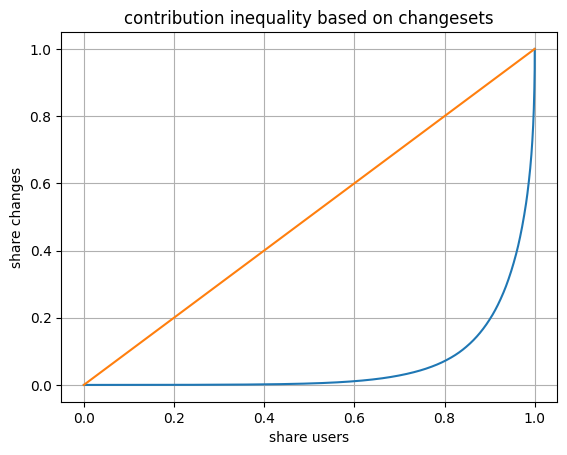

In [11]:
import matplotlib.pyplot as plt 

gini_coefficient = gini(
    df_users["num_changes"].values  # we need an array
)
print(f"Gini coefficient: {gini_coefficient}")

# calculate lorenz curve
lorenz_curve = lorenz(
    df_users["num_changes"].values  # we need an array
)

# we need the X values to be between 0.0 to 1.0
plt.plot(np.linspace(0.0, 1.0, lorenz_curve.size), lorenz_curve)
plt.plot([0,1], [0,1])  # plot the straight line perfect equality curve

plt.title("contribution inequality based on changesets")
plt.xlabel("share users")
plt.ylabel("share changes")
plt.grid()
plt.show()

#### Filter changesets for different user groups
Here we filter changesets by comments and users.
Changeset comments offer another quick way to differentiate different types of mapping. Here we want to check on organized mapping activities.

Filter for all changesets which contain "hotosm" in the changeset comment.
Save the filtered data into the geopackage.

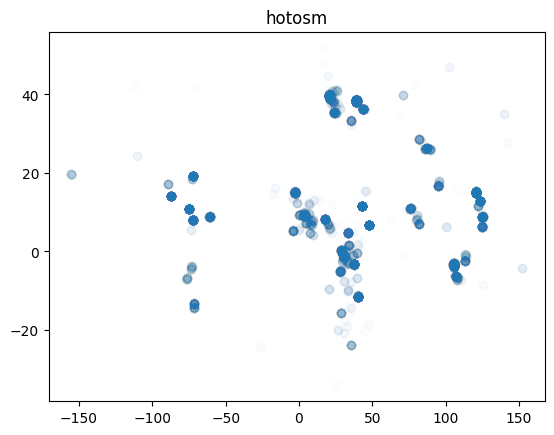

'hot users: 899'

In [32]:
# define keyword that we'll use to filter
keyword = "hotosm"

# filter by user_names defined in csv file
df_filtered_hotosm = df[
    df["comment"].str.contains(
        keyword,
        case=False,  # case insensitive
        na=False  # ignore changesets without comments
    )
]

plt.scatter(
    df_filtered_hotosm["geometry"].x,  # get x coordinate from geometry
    df_filtered_hotosm["geometry"].y,  # get y coordinate from geometry
    alpha=0.01  # make sure to use a very low value here to avoid too much overplotting
)
plt.title("hotosm")
plt.show()

# write filtered dataframe to geopackage
df_filtered_hotosm.to_file(
    "changesets.gpkg",
    layer="changesets_hotosm_centroids",
    driver="GPKG"
)

display(f"hot users: {df_filtered_hotosm['user_id'].nunique()}")

When companies map in OSM they often make public which users are mapping on their behalf. Filtering for users in changesets is another way to investigate the impact of corporate mapping on overall OSM mapping. Both companies document their organized editing activity. For Facebook you can check the OSM Wiki and for Apple you will find information on their OSM mappers on Github.

Filter for all changesets created by users listed in a) facebook_users.csv and b) apple_users.csv.
Save the filtered data into the geopackage.

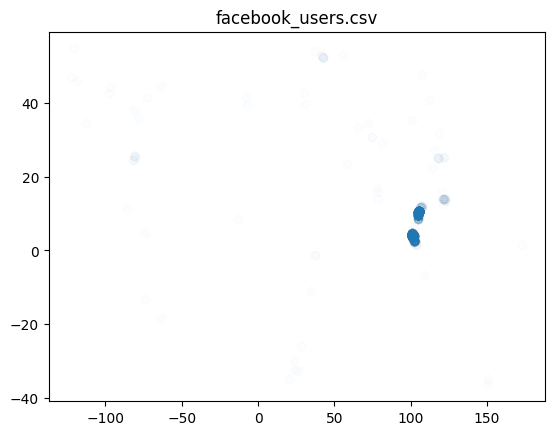

'facebook_users.csv: 40'

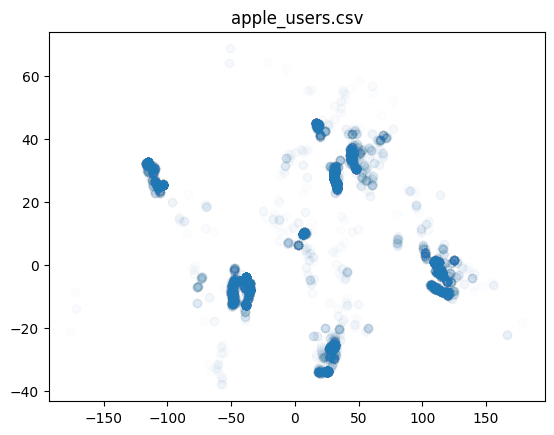

'apple_users.csv: 433'

In [31]:
import pandas as pd

files = [
    "facebook_users.csv",
    "apple_users.csv"
]

for file in files:
    corporate_mappers_df = pd.read_csv(file)

    # filter by user_names defined in csv file
    df_filtered = df[
        df["user_name"].isin(corporate_mappers_df["user_name"])
    ]
    
    plt.scatter(
        df_filtered["geometry"].x,  # get x coordinate from geometry
        df_filtered["geometry"].y,  # get y coordinate from geometry
        alpha=0.01  # make sure to use a very low value here to avoid too much overplotting
    )
    plt.title(file)
    plt.show()

    #write filtered dataframe to geopackage
    df_filtered.to_file(
        "changesets.gpkg",
        layer="changesets_facebook_centroids",
        driver="GPKG"
    )

    display(f"{file}: {df_filtered['user_id'].nunique()}")

### 4. Conclusion

Obviously our analysis has been relatively simple here, since we did not look into what has actually been mapped. Nevertheless, looking at the metadata captured in changesets is often a good starting point to test assumptions. Often you will do a more detailed analysis using the actual OSM data (e.g. contributions) in a subsequent step when you know better what to look out for.